In [1]:
%matplotlib inline
import datetime as datetime
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import text
plt.style.use("bmh")
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = '14'
import numpy as np
from numpy import trapz
import pandas as pd
import seaborn as sns

## Loading DataFrames

In [2]:
sdf = pd.read_pickle('Your/Data/Path/sample_dataframe_final.pkl')
sdf

,text,created_at,entities.mentions,entities.annotations,entities.hashtags,text_processed,is_reply,referenced_type,length,tweet_count,created_truncated
0,@Panchin083 Hahahah i wuv you https://t.co/Z4H...,2019-01-01 04:30:12+00:00,NaN,NaN,NaN,"[hahahah, wuv, <-url->]",True,replied_to,53,1,2019-01-01
1,@ViciousRalph Why you doubt yourself? Figure o...,2019-01-01 04:30:12+00:00,NaN,NaN,NaN,"[doubt, figure, need, work, better, keep, head...",True,replied_to,158,1,2019-01-01
2,RT @tcm: Still struggling to find the perfect ...,2019-01-01 04:30:12+00:00,"[{'start': 3, 'end': 7, 'username': 'tcm', 'id...",NaN,NaN,"[still, struggling, find, perfect, cocktail, r...",False,retweeted,140,1,2019-01-01
3,RT @emilyxsnapp: fuck https://t.co/oBcfD6HPgj,2019-01-01 04:30:12+00:00,NaN,NaN,NaN,"[fuck, <-url->]",False,retweeted,45,1,2019-01-01
4,RT @entwinedglobal: We wish you all a prospero...,2019-01-01 04:30:12+00:00,"[{'start': 3, 'end': 18, 'username': 'entwined...","[{'start': 71, 'end': 73, 'probability': 0.917...",NaN,"[wish, prosperous, new, year, full, god's, ble...",False,retweeted,140,1,2019-01-01
...,...,...,...,...,...,...,...,...,...,...,...
919524,RT @EliseiNicole: #UK Manchester Parklife Fest...,2021-09-12 18:20:53+00:00,"[{'start': 3, 'end': 16, 'username': 'EliseiNi...","[{'start': 22, 'end': 49, 'probability': 0.330...","[{'start': 18, 'end': 21, 'tag': 'UK'}]","[#uk, manchester, parklife, festival, <-url->,...",False,retweeted,103,1,2021-09-12
919525,Yaqoob (ع) cried for 40 years even though Yous...,2021-09-12 18:20:53+00:00,NaN,"[{'start': 42, 'end': 47, 'probability': 0.848...","[{'start': 170, 'end': 193, 'tag': 'Leadership...","[yaqoob, cried, years, even, though, yousuf, a...",False,NaN,217,1,2021-09-12
919526,@sopeoIogist outro tear is yours,2021-09-12 18:20:53+00:00,"[{'start': 0, 'end': 12, 'username': 'sopeoIog...",NaN,NaN,"[outro, tear]",True,replied_to,35,1,2021-09-12
919527,Turn on Air-Con! The current temperature is 26...,2021-09-12 18:20:53+00:00,NaN,NaN,NaN,"[turn, air-con, current, temperature, <-url->,...",False,NaN,69,1,2021-09-12


## Functions

In [3]:
# Functions for preparing the dataframe
# --- Read keywords from file and return them as list
def prepare_keywords(file):
    keys = pd.read_csv(file)
    s = ''
    return [(s+word) for word in keys['keywords']]

# --- Create new column with value=1 if keyword is in tweet and value=0 if not
def covid_relation(df, keylist):
    return df.assign(covid_related=df['text_processed'].apply(lambda t: 1 if any(f" {keyword} " in ' '.join(t) for keyword in keylist) else 0))

# --- Create new column by inverting the column created above
def no_covid_relation(df, keylist):
    return df.assign(not_covid_related=df['covid_related'].apply(lambda t: 0 if t==1 else 1))

In [4]:
# Functions for plotting
# --- Detrender removes trends over period to better identify significant short time changes
def detrender(df, periods=None, method=None):
    periods = 30 if periods is None else periods
    func = np.mean if method is None else method

    return df - df.rolling(periods).apply(func)

# --- Put the data in the dataframe in units of deviation from the mean.
def standardize(df):
    return (df - df.mean()) / df.std()

# --- Plots input dataframe and adds lines for sigma-levels 1 to 3
def make_normalplot(df, random=True):
    if random:
        plt.plot(df.index.values,
                 np.random.normal(size=df.shape[0]),
                 lw=0.8,
                 alpha=0.75)
        plt.ylim((-5, 5))
        plt.title("Generated normal time series with $\sigma$ bands")
    else:
        plt.plot(df.index.values, df.values, lw=0.8, alpha=0.75)
        #plt.ylim((-5, 8))
        plt.title("Dataframe with bands showing up to 3 sigma")

    plt.axhline(y=1, color="red")
    plt.axhline(y=-1, color="red")
    plt.axhline(y=2, color="orange")
    plt.axhline(y=-2, color="orange")
    plt.axhline(y=3, color="yellow")
    plt.axhline(y=-3, color="yellow")

    arrowprops = dict(arrowstyle="-",
                      color="black",
                      lw=2)

    #textprops = dict(rotation="vertical", fontsize=16)
    textprops = dict()

    plt.annotate("1 $\sigma$",
                 xy=(df.index.values[10], 1),
                 xytext=(df.index.values[10], -1.5),
                 arrowprops=arrowprops,
                 **textprops)

    plt.annotate("2 $\sigma$",
                 xy=(df.index.values[50], 2),
                 xytext=(df.index.values[50], -2.5),
                 arrowprops=arrowprops,
                 **textprops
                 )

    plt.annotate("3 $\sigma$",
                 xy=(df.index.values[100], 3),
                 xytext=(df.index.values[100], -3.5),
                 arrowprops=arrowprops,
                 **textprops
                 )
        
#make_normalplot(ddf, random=True)

# --- Plot input dataframe and add date_markers
def plot_ts(series,
            ma=False,
            raw=False,
            expanding=False,
            ewma=False,
            overall=False,
            median=False,
            title=None,
            time_bin="hour",
            date_markers=None,
            y_label=None,
            custom_yaxis=None,
            custom_ax=None,
            **kwargs):
    """
    custom plotting function for our time-series dataframes. 
    Args:
        series: pd.Series or pd.Dataframe
        raw: plot the basic values in the frame
        expanding: plot an expanding mean
        ewma: plot an ewma line
        overall: plot an overall mean
        median: plot the overall median
        title: custom title to use
        time_bin: marks the y-axis correctly
        date_markers: plots a dot on the signal where a given date is noted.
        y_label: custom y-axis label
        custom_yaxis: custom axis
        custom_ax: passing a custom Axes here will assign this plot to that
                   axis
   """
    if isinstance(series, pd.DataFrame):
        series = series["counts"]

    lw = 0.75
    if custom_ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    else:
        ax = custom_ax

    if y_label is None:
        period = series.index.to_period().freqstr
        _bin = "day" if period == "D" else "hour"
        _y_label = "tweets per {}".format(_bin)
        plt.ylabel(_y_label)
    else:
        if isinstance(y_label, str):
            plt.ylabel(y_label)

    if date_markers is not None:
        def dateindex_to_str(index, include_hour=True):
            idx = 16 if include_hour else 10
            return [str(date)[0:idx].replace("T", " ")
                    for date in index.values]

        (ax.plot(date_markers, series.loc[date_markers],
                 "o", markersize=4, color='m', label="point"))

    if raw:
        series.plot(label="raw", lw=lw, ax=ax)

    if ma:
        (series.rolling(ma).mean()
         .plot(ax=ax, label="{}{} ma".format(ma, time_bin), lw=lw))

    if ewma:
        if isinstance(ewma, int):
            (series.ewm(span=ewma).mean()
             .plot(ax=ax, label="emwa - span {}".format(ewma), lw=lw))
        else:
            (series.ewm(alpha=0.05).mean()
             .plot(ax=ax, label="emwa, $\alpha = 0.05$", lw=lw))

    if expanding:
        series.expanding().mean().plot(ax=ax, label="expanding_mean", lw=lw)

    if overall:
        (pd.DataFrame(series)
         .assign(global_mean=lambda x: x['count']
                 .mean())["global_mean"]
         .plot(ax=ax, label="global_mean", lw=lw))

    if median:
        (pd.DataFrame(series)
         .assign(global_median=lambda x: x['count'].median())["global_median"]
         .plot(ax=ax, label="global_median"))

    plt.tight_layout()
    plt.xlabel("datetime")

    if custom_yaxis is not None:
        def log_axis(x, pos):
            'The two args are the value and tick position'
            str_ = '$' + "2^{" + str(x) + "}" + '$'
            return str_
        formatter = FuncFormatter(log_axis)
        ax.yaxis.set_major_formatter(formatter)

    if title:
        ax.set_title(title)
    if custom_ax is not None:
        return
    else:
        return ax

#plt.rcParams["figure.figsize"] = (20,5)
#plot_ts(ddf, raw=True, title="$ln$ transformed standardized $\Delta$ Tweets from previous hour")

## Analysis Hypothesis 2.1 SAMPLE

##### Import keywords

In [5]:
# Load keywords identified in the "Coronavirus (COVID-19) Tweets Dataset" by Lamsal
keylist = prepare_keywords('keywords.txt')
keylist

['corona',
 '#corona',
 'coronavirus',
 '#coronavirus',
 'covid',
 '#covid',
 'covid19',
 '#covid19',
 'covid-19',
 '#covid-19',
 'sarscov2',
 '#sarscov2',
 'sars cov2',
 'sars cov 2',
 'covid_19',
 '#covid_19',
 '#ncov',
 'ncov',
 '#ncov2019',
 'ncov2019',
 '2019-ncov',
 '#2019-ncov',
 'pandemic',
 '#pandemic',
 '#2019ncov',
 '2019ncov',
 'quarantine',
 '#quarantine',
 'flatten the curve',
 'flattening the curve',
 '#flatteningthecurve',
 '#flattenthecurve',
 'hand sanitizer',
 '#handsanitizer',
 '#lockdown',
 'lockdown',
 'social distancing',
 '#socialdistancing',
 'work from home',
 '#workfromhome',
 'working from home',
 '#workingfromhome',
 'ppe',
 'n95',
 '#ppe',
 '#n95',
 '#covidiots',
 'covidiots',
 'herd immunity',
 '#herdimmunity',
 'pneumonia',
 '#pneumonia',
 'chinese virus',
 '#chinesevirus',
 'wuhan virus',
 '#wuhanvirus',
 'kung flu',
 '#kungflu',
 'wearamask',
 '#wearamask',
 'wear a mask',
 'vaccine',
 'vaccines',
 '#vaccine',
 '#vaccines',
 'corona vaccine',
 'corona 

##### Check tweets for COVID-keywords

In [6]:
# Drop columns not needed for this analysis,
# then check if tweet contains COVID keywords
# and add inversion of check as another column
ctdf = (sdf
       .drop(columns=['text', 'created_truncated', 'referenced_type',
                      'entities.mentions', 'entities.annotations', 'entities.hashtags',
                      'is_reply', 'length'])
       .pipe(covid_relation, keylist)
       .pipe(no_covid_relation, keylist)
      )
ctdf

,created_at,text_processed,tweet_count,covid_related,not_covid_related
0,2019-01-01 04:30:12+00:00,"[hahahah, wuv, <-url->]",1,0,1
1,2019-01-01 04:30:12+00:00,"[doubt, figure, need, work, better, keep, head...",1,0,1
2,2019-01-01 04:30:12+00:00,"[still, struggling, find, perfect, cocktail, r...",1,0,1
3,2019-01-01 04:30:12+00:00,"[fuck, <-url->]",1,0,1
4,2019-01-01 04:30:12+00:00,"[wish, prosperous, new, year, full, god's, ble...",1,0,1
...,...,...,...,...,...
919524,2021-09-12 18:20:53+00:00,"[#uk, manchester, parklife, festival, <-url->,...",1,0,1
919525,2021-09-12 18:20:53+00:00,"[yaqoob, cried, years, even, though, yousuf, a...",1,0,1
919526,2021-09-12 18:20:53+00:00,"[outro, tear]",1,0,1
919527,2021-09-12 18:20:53+00:00,"[turn, air-con, current, temperature, <-url->,...",1,0,1


##### Prepare dataframes for analysis

In [7]:
# Set up dataframe for further analysis 
# with total/COVID/non-COVID tweet counts per day
ddf =(ctdf
      .set_index('created_at')
      .sort_index()
      .resample('d')
      .sum()
     )
ddf

,tweet_count,covid_related,not_covid_related
created_at,,,
2019-01-01 00:00:00+00:00,948,0,948
2019-01-02 00:00:00+00:00,952,0,952
2019-01-03 00:00:00+00:00,945,0,945
2019-01-04 00:00:00+00:00,937,0,937
2019-01-05 00:00:00+00:00,939,0,939
...,...,...,...
2021-09-08 00:00:00+00:00,693,4,689
2021-09-09 00:00:00+00:00,719,3,716
2021-09-10 00:00:00+00:00,666,15,651


In [8]:
# Create dataframe with percentage of COVID-related and
# non-COVID-related communication
ddf_perc_ges = (ddf[['not_covid_related', 'covid_related']]
                .divide(ddf[['not_covid_related', 'covid_related']].sum(axis=1), axis=0)
               )
ddf_perc_ges

,not_covid_related,covid_related
created_at,,
2019-01-01 00:00:00+00:00,1.000000,0.000000
2019-01-02 00:00:00+00:00,1.000000,0.000000
2019-01-03 00:00:00+00:00,1.000000,0.000000
2019-01-04 00:00:00+00:00,1.000000,0.000000
2019-01-05 00:00:00+00:00,1.000000,0.000000
...,...,...
2021-09-08 00:00:00+00:00,0.994228,0.005772
2021-09-09 00:00:00+00:00,0.995828,0.004172
2021-09-10 00:00:00+00:00,0.977477,0.022523


##### Analyse for significant change in non-COVID-related communication

           counts
count  985.000000
mean    -0.000736
std      0.615374
min     -5.215775
25%     -0.201711
50%      0.000000
75%      0.207081
max      3.745354


c:\Users\johan\anaconda3\envs\vw_project_env\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


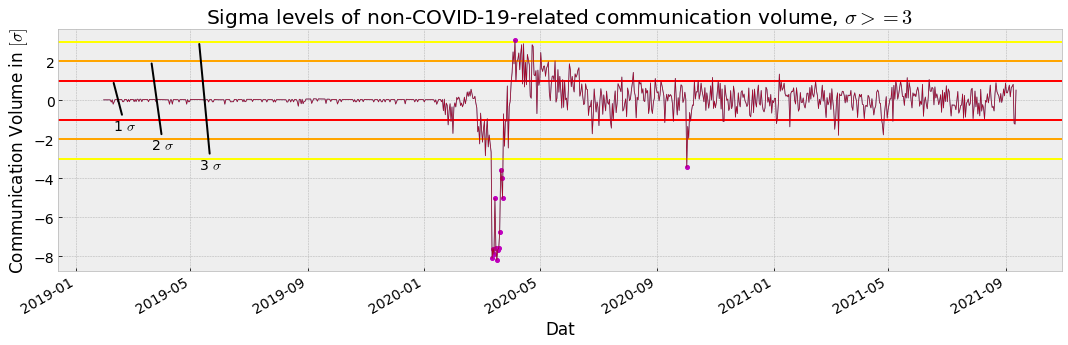

In [9]:
# Convert dataframe values to percentages
counts_ddf = ddf_perc_ges['not_covid_related'].to_frame(name="counts").multiply(100)

print(counts_ddf.diff().describe())

# Configure sigma-level threshold and plot size
UNIT_THRESHOLD = 3
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (15, 5))

# Create first layer in plot - Plot sigma-level for relative change in non-COVID-related communication
(counts_ddf
 .pipe(detrender)
 .dropna()
 .pipe(standardize)
 .pipe(make_normalplot, random=False))

# Create second layer in plot - Plot same graph as in first layer but instead of sigma-level
# add date_markers showing all dates that are above/below a sigma-level 3 threshold
plot_ts(counts_ddf
        .pipe(detrender)
        .dropna()
        .pipe(standardize),
        raw=True,
        title=f"Sigma levels of non-COVID-19-related communication volume, $\sigma >={UNIT_THRESHOLD}$",
        custom_ax=axes,
        date_markers=(counts_ddf
                      .pipe(detrender)
                      .dropna()
                      .pipe(standardize)
                      .query("counts >= @UNIT_THRESHOLD | counts <= -@UNIT_THRESHOLD")
                      .index));

axes.set_xlabel('Dat')
axes.set_ylabel(r'Communication Volume in $[\sigma]$')
plt.savefig('A1_4 Analysis of significance of non-COVID-19-related Communication Volume Sigma Levels SAMPLE.png', bbox_inches='tight')

           counts
count  985.000000
mean    -0.000736
std      0.615374
min     -5.215775
25%     -0.201711
50%      0.000000
75%      0.207081
max      3.745354
DatetimeIndex(['2020-03-12 00:00:00+00:00', '2020-03-13 00:00:00+00:00',
               '2020-03-14 00:00:00+00:00', '2020-03-15 00:00:00+00:00',
               '2020-03-16 00:00:00+00:00', '2020-03-17 00:00:00+00:00',
               '2020-03-18 00:00:00+00:00', '2020-03-19 00:00:00+00:00',
               '2020-03-20 00:00:00+00:00', '2020-03-21 00:00:00+00:00',
               '2020-03-22 00:00:00+00:00', '2020-03-23 00:00:00+00:00',
               '2020-04-05 00:00:00+00:00', '2020-10-02 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='created_at', freq=None)


c:\Users\johan\anaconda3\envs\vw_project_env\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


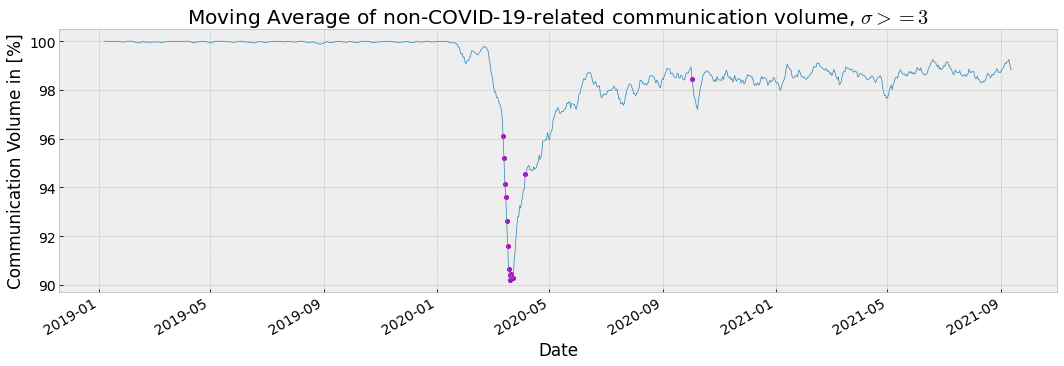

In [10]:
# Convert dataframe values to percentages
counts_ddf = ddf_perc_ges['not_covid_related'].to_frame(name="counts").multiply(100)

print(counts_ddf.diff().describe())

# Calculate and print dates with significant increase (sigma-level >= |3|)
# of non-COVID-related communication
print((counts_ddf
                      #.pipe(np.log)
                      .pipe(detrender)
                      .dropna()
                      .pipe(standardize)
                      .query("counts >= @UNIT_THRESHOLD | counts <= -@UNIT_THRESHOLD")
                      .index))

# Configure sigma-level threshold and plot size
UNIT_THRESHOLD = 3
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (15, 5))

# Plot timeseries of non-COVID-related communication with date_markers
plot_ts(counts_ddf
        .rolling(7)
        .mean(),
        raw=True,
        title=f"Moving Average of non-COVID-19-related communication volume, $\sigma >={UNIT_THRESHOLD}$",
        custom_ax=axes,
        date_markers=(counts_ddf
                      #.pipe(np.log)
                      .pipe(detrender)
                      .dropna()
                      .pipe(standardize)
                      .query("counts >= @UNIT_THRESHOLD | counts <= -@UNIT_THRESHOLD")
                      .index));

axes.set_xlabel('Date')
axes.set_ylabel('Communication Volume in [%]')
plt.savefig('A1_4 Analysis of significance of non-COVID-19-realted Communication SAMPLE.png', bbox_inches='tight')

## Research Question A - SAMPLE Dataset

area = 594.5146989589716


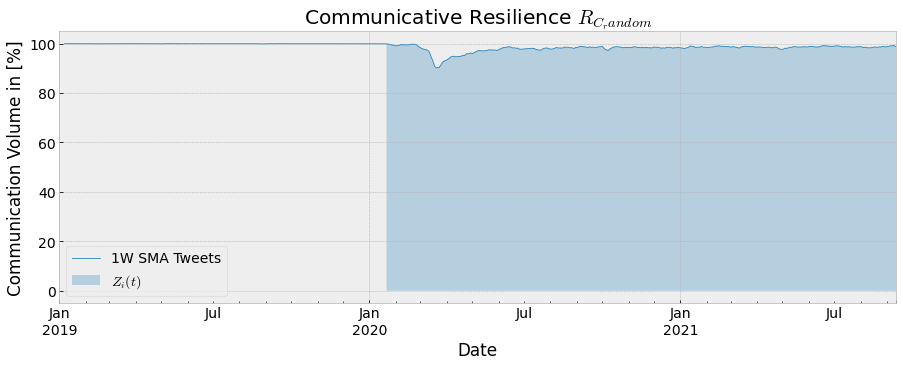

In [11]:
# Setup deduced dataframe with only dates during the pandemic (15.01.2020 onwards)
crisis_df = ddf_perc_ges['not_covid_related'].loc[(ddf_perc_ges.index >= '2020-01-15')]

# The y values.  A numpy array is used here,
# but a python list could also be used.
y = crisis_df.tolist()

# The x values. Calculated by starting at sample x-position 0 
# and then adding the difference to the next date in days to the position
x = [0]
for i in range(len(crisis_df.index)-1):
    x.append(x[i] + (crisis_df.index[i+1] - crisis_df.index[i]).days
)

# Compute the area using the composite trapezoidal rule.
# This equals the resilience value R_C_random
area = trapz(y, x)
print("area =", area)

# Configure plot size
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (15, 5))

# Plot timeseries for non-COVID-related communication percentage
(ddf_perc_ges['not_covid_related']
 .multiply(100)
 .rolling(7)
 .mean()
 .plot(ax=axes, lw=0.9, label='1W SMA Tweets'));

# Fill area covered by non-COVID-related communication during crisis (blue)
axes.fill_between(crisis_df
                  .index, 
                  crisis_df
                  .multiply(100)
                  .rolling(7)
                  .mean(),
                  alpha=0.3,
                  label=r'$Z_{i}(t)$'
                 )

axes.legend()
axes.set_xlabel('Date')
axes.set_ylabel('Communication Volume in [%]')
axes.set_title(r'Communicative Resilience $R_{C_random}$')
plt.savefig('A1_4 Communicative Resilience total SAMPLE.png', bbox_inches='tight')